Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 1

#### Objectives
- define the problem at hand and the data on which you’ll train
- choose how you’ll measure success on your problem
- get and interpret the confusion matrix for classification models
- use classification metrics: precision, recall
- understand the relationships between precision, recall, thresholds, and predicted probabilities
- understand how Precision@K can help make decisions and allocate budgets

### Setup

#### If you're using [Anaconda](https://www.anaconda.com/distribution/) locally

Install required Python package, if you haven't already:

[category_encoders](http://contrib.scikit-learn.org/categorical-encoding/), version >= 2.0  

`conda install -c conda-forge category_encoders`

or

`pip install --upgrade category_encoders`

In [ ]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python package:
    # category_encoders, version >= 2.0
    !pip install --upgrade category_encoders
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Applied-Modeling.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5 (delta 1), reused 5 (delta 1), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/LambdaSchool/DS-Unit-2-Applied-Modeling
 * branch            master     -> FETCH_HEAD
   4d23ee7..0949ddd  master     -> origin/master
Updating 4d23ee7..0949ddd
Fast-forward
 module1/assignment_applied_modeling_1.ipynb |   52 ++
 module1/lesson_applied_modeling_1.ipynb     | 1199 +++++++++++++++++++++++++++
 2 files changed, 1251 insertions(+)
 create mode 100644 module1/assignment_applied_modeling_1.ipynb
 create mode 100644 module1/lesson_applied_modeling_1.ipynb


#### Don't use Matplotlib version 3.1.1

Why? Because of this issue: [sns.heatmap top and bottom boxes are cut off](https://github.com/mwaskom/seaborn/issues/1773)

> This was a matplotlib regression introduced in 3.1.1 which has been fixed in 3.1.2 (still forthcoming). For now the fix is to downgrade matplotlib to a prior version.

If you the following cell throws an `AssertionError`, then you have matplotlib version 3.1.1, and you may want to downgrade to version 3.1.0 to run this notebook: `pip install matplotlib==3.1.0`

In [ ]:
from distutils.version import StrictVersion
import matplotlib
version = matplotlib.__version__
print('Matplotlib version', version)
assert StrictVersion(version) != StrictVersion('3.1.0')

Matplotlib version 3.0.3


## Process for Data Science

#### Renee Teate, [Becoming a Data Scientist, PyData DC 2016 Talk](https://www.becomingadatascientist.com/2016/10/11/pydata-dc-2016-talk/)

![](https://image.slidesharecdn.com/becomingadatascientistadvice-pydatadc-shared-161012184823/95/becoming-a-data-scientist-advice-from-my-podcast-guests-55-638.jpg?cb=1476298295)


#### _This diagram is general and high-level. How do we apply it when doing predictive modeling with labeled, tabular data?_

Business Question ➡ Data Question = steps 1-3 below

Data Question ➡ Data Answer = steps 4-6 below

## Process for Supervised Learning

#### Francois Chollet, [Deep Learning with Python](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/README.md), Chapter 4: Fundamentals of machine learning, "A universal workflow of machine learning"
 
> **1. Define the problem at hand and the data on which you’ll train.** Collect this data, or annotate it with labels if need be.

> **2. Choose how you’ll measure success on your problem.** Which metrics will you monitor on your validation data?

> **3. Determine your evaluation protocol:** hold-out validation? K-fold validation? Which portion of the data should you use for validation?

> **4. Develop a first model that does better than a basic baseline:** a model with statistical power.

> **5. Develop a model that overfits.** The universal tension in machine learning is between optimization and generalization; the ideal model is one that stands right at the border between underfitting and overfitting; between undercapacity and overcapacity. To figure out where this border lies, first you must cross it.

> **6. Regularize your model and tune its hyperparameters, based on performance on the validation data.** Repeatedly modify your model, train it, evaluate on your validation data (not the test data, at this point), modify it again, and repeat, until the model is as good as it can get. 

> **Iterate on feature engineering: add new features, or remove features that don’t seem to be informative.** Once you’ve developed a satisfactory model configuration, you can train your final production model on all the available data (training and validation) and evaluate it one last time on the test set.


## 1. Define the problem at hand and the data on which you'll train

This isn't easy! You have to define your target, join tables, and avoid leakage. This opinionated blog post explains:

#### [Data Science Is Not Taught At Universities - And Here Is Why](https://www.linkedin.com/pulse/data-science-taught-universities-here-why-maciej-wasiak/)

> The tables they use in machine learning research already have the target information clearly defined. Here comes the famous IRIS dataset, then the Wisconsin Breast Cancer, there is even Credit Risk or Telco Churn data and they all have the **Target** column there ...

> The problem is that in real life the **Target** flag is NEVER there.

> For churn modelling you may have many churn types on the system and need to distil the few that need modelling. And hey - when a subscriber moves from Postpaid contract to Prepaid – is this a churn or not? (‘Yes’ – says the Postpaid Base Manager, ‘No’ says the CEO ). You have to make the call ...

> Your source will be a database with tens or hundreds of **tables**, millions of records, usually after 3 painful migrations with gaps in history, columns without descriptions ...

> Flooded by **leaks from the future**, ...a dozen of other traps ... And you need to disarm all of them, because even one left behind may result in a completely useless model. 

> These are the skills employers are looking for.



## Regression or Classification?

#### You can convert problems from regression to classification

1. UCI, [Adult Census Income dataset](https://archive.ics.uci.edu/ml/datasets/adult)

2. DS5 student Han Lee, [Bitcoin Price Prediction app](https://dry-shore-97069.herokuapp.com/about):

> We also cared a lot more about the direction of returns instead of magnitude of returns. A trade placed based on the prediction that the price to go up tomorrow will be fine if the magnitude is off but will be unprofitable if the direction is wrong. ... Yesterday's return is unsurprising a great predictor for today's return, but has a poor directional accuracy.

#### You can convert problems from classification to regression

Brandon Rohrer, [What questions can machine learning answer](https://brohrer.github.io/five_questions_data_science_answers.html)

> Sometimes questions that look like multi-value classification questions are actually better suited to regression. For instance, “Which news story is the most interesting to this reader?” appears to ask for a category—a single item from the list of news stories. However, you can reformulate it to “How interesting is each story on this list to this reader?” and give each article a numerical score. Then it is a simple thing to identify the highest-scoring article. Questions of this type often occur as rankings or comparisons.

> “Which van in my fleet needs servicing the most?” can be rephrased as “How badly does each van in my fleet need servicing?” 
“Which 5% of my customers will leave my business for a competitor in the next year?” can be rephrased as “How likely is each of my customers to leave my business for a competitor in the next year?” 

> Binary classification problems can also be reformulated as regression. (In fact, under the hood some algorithms reformulate every binary classification as regression.) This is especially helpful when an example can belong part A and part B, or have a chance of going either way. When an answer can be partly yes and no, probably on but possibly off, then regression can reflect that. Questions of this type often begin “How likely…” or “What fraction…”

> How likely is this user to click on my ad? What fraction of pulls on this slot machine result in payout? How likely is this employee to be an insider security threat? What fraction of today’s flights will depart on time?

We'll see examples of this, using predicted probabilities instead of discrete predictions, with Tanzania Waterpumps and Lending Club data.

#### You can convert multi-class classification to binary classification

By omitting or combining some classes. We'll also see examples of this, with Tanzania Waterpumps and Lending Club data.

## Lending Club example 🏦

### Background

[According to Wikipedia,](https://en.wikipedia.org/wiki/Lending_Club)

> Lending Club is the world's largest peer-to-peer lending platform. Lending Club enables borrowers to create unsecured personal loans between \$1,000 and \$40,000. The standard loan period is three years. Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.

[Lending Club says,](https://www.lendingclub.com/) "Our mission is to transform the banking system to make credit more affordable and investing more rewarding." You can view their [loan statistics and visualizations](https://www.lendingclub.com/info/demand-and-credit-profile.action).

Lending Club's [Investor Education Center](https://www.lendingclub.com/investing/investor-education) can help you grow your domain expertise. The article about [Benefits of diversification](https://www.lendingclub.com/investing/investor-education/benefits-of-diversification) explains,

> With the investment minimum of \$1,000, you can get up to 40 Notes at \$25 each.

![](https://i.ibb.co/B37q8LB/www-lendingclub-com-browse-browse-action-1.png)

### Data sources
- [Current loans](https://www.lendingclub.com/browse/browse.action)
- [Data Dictionary & Historical loans](https://www.lendingclub.com/info/download-data.action) (17 zip files, 450 MB total)

### What questions could we ask with this data?
1. Can we predict the interest rate that Lending Club will assign to a loan, to reverse engineer their formula. (Regression problem. Can only use info from before the interest rate was assigned)
2. Can we predict whether a loan will be fully paid or charged off, to choose which loans to invest in. (Classification problem. Can only use info available at the time you choose loans, from loans that have been fully paid or charged off.)

[Here's a Plotly Dash app for #1](https://rrherr-project2-example.herokuapp.com/).

This notebook will work on #2.


### Use a subset of Loan Status

#### [Data-Driven Investment Strategies for Peer-to-Peer Lending: A Case Study for Teaching Data Science](https://www.liebertpub.com/doi/full/10.1089/big.2018.0092)

> Current refers to a loan that is still being reimbursed in a timely manner. Late corresponds to a loan on which a payment is between 16 and 120 days overdue. If the payment is delayed by more than 121 days, the loan is considered to be in Default. If LendingClub has decided that the loan will not be paid off, then it is given the status of Charged-Off.

> These dynamics imply that 5 months after the term of each loan has ended, every loan ends in one of two LendingClub states—fully paid or charged-off. We call these two statuses fully paid and defaulted, respectively, and we refer to a loan that has reached one of these statuses as expired.

> **One way to simplify the problem is to consider only loans that have expired at the time of analysis.**

> A significant portion (13.5%) of loans ended in Default status; depending on how much of the loan was paid back, these loans
might have resulted in a significant loss to investors who had invested in them. The remainder was Fully Paid—the borrower fully reimbursed the loan’s outstanding balance with interest, and the investor earned a positive return on his or her investment. Therefore, to avoid unsuccessful investments, our goal is to estimate which loans are more likely to default and which will yield low returns. 

### Use a subset of Loan Grade

[Lending Club announced,](https://blog.lendingclub.com/q1-2019-platform-update) 

> We periodically adjust platform products to reflect changes in investor demand and other marketplace factors. As a result, this quarter we are retiring Grade E loans. As of May 7, 2019, we will no longer facilitate new Grade E loans except for certain previously qualified or approved loans; **effective July 1, 2019, no grade E loans will be available on the platform.**

In [ ]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

history_location = '../data/lending-club/lending-club-subset.csv'
current_location = '../data/lending-club/primaryMarketNotes_browseNotes_1-RETAIL.csv'

# Stratified sample, 10% of expired Lending Club loans, grades A-D
# Source: https://www.lendingclub.com/info/download-data.action
history = pd.read_csv(history_location)
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)

# Current loans available for manual investing, June 17, 2019
# Source: https://www.lendingclub.com/browse/browse.action
current = pd.read_csv(current_location)

In [ ]:
# In the original raw data, there were more categories in 
# the target column, including the most frequent category, "In Progress"
history['loan_status'].value_counts(normalize=True)

Fully Paid     0.824855
Charged Off    0.175145
Name: loan_status, dtype: float64

In [ ]:
# Calculate percent of each loan repaid
history['percent_paid'] = history['total_pymnt'] / history['funded_amnt']

# See percent paid for charged off vs fully paid loans
history.groupby('loan_status')['percent_paid'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,22477.0,0.546541,0.278077,0.0,0.327761,0.514006,0.742090,1.490546
Fully Paid,105857.0,1.146904,0.089759,1.0,1.083836,1.132098,1.195798,1.623628


### Begin with baselines: expected value of random decisions

[You May Be Better Off Picking Stocks at Random, Study Finds](https://news.ycombinator.com/item?id=20724338)

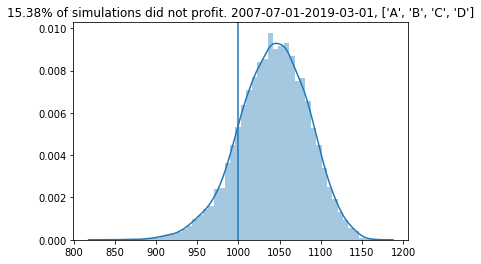

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
import seaborn as sns
from tqdm import tnrange

def simulate(n=10000, grades=['A','B','C','D'], 
             start_date='2007-07-01', 
             end_date='2019-03-01'):
    """
    What if you picked 40 random loans for $25 investments?
    How much would you have been paid back?
    
    Repeat the simulation many times, and plot the distribution 
    of probable outcomes.
    
    This doesn't consider fees or "time value of money."
    """
    
    condition = ((history['grade'].isin(grades)) & 
                 (history['issue_d'] >= start_date) &
                 (history['issue_d'] <= end_date))
    possible = history[condition]
    
    simulations = []
    for _ in tnrange(n):
        picks = possible.sample(40).copy()
        picks['paid'] = 25 * picks['percent_paid']
        paid = picks['paid'].sum()
        simulations.append(paid)
        
    simulations = pd.Series(simulations)
    sns.distplot(simulations)
    plt.axvline(x=1000)
    percent = percentileofscore(simulations, 1000)
    plt.title(f'{percent}% of simulations did not profit. {start_date}-{end_date}, {grades}')

simulate()

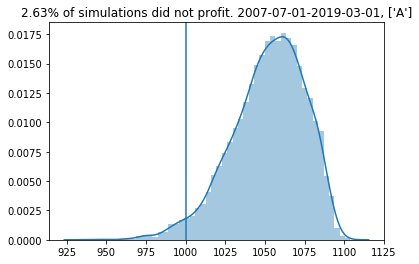

In [ ]:
simulate(grades=['A'])

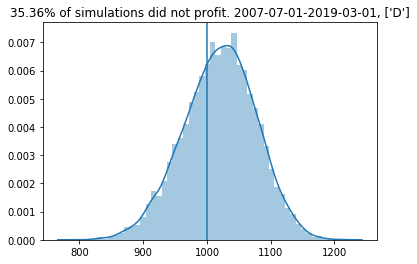

In [ ]:
simulate(grades=['D'])

### Use a subset of features

What subset of features should we use, to avoid leakage?

In [ ]:
history.shape, current.shape

((128334, 151), (58, 122))

In [ ]:
# Use Python sets to compare the historical columns & current columns
common_columns = set(history.columns) & set(current.columns)
just_history = set(history.columns) - set(current.columns)
just_current = set(current.columns) - set(history.columns)

## 2. Choose your evaluation metric: how you’ll measure success on your problem

What are some of your [options](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)? Let's go back to Tanzania Waterpumps to learn about some new options.

## Tanzania Waterpumps example🚰

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')


# Split train into train & val. Make val the same size as test.
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train['status_group'], random_state=42)

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [ ]:
# Arrange data into X features matrix and y target vector
target = 'status_group'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [ ]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8081905557877141


## Get and interpret the confusion matrix for classification models

[Scikit-Learn User Guide — Confusion Matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)

In [ ]:
# This is hard to read
from sklearn.metrics import confusion_matrix
y_pred = pipeline.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[6959,  177,  662],
       [ 550,  328,  165],
       [1123,   77, 4317]])

In [ ]:
# We need to get labels
from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

array(['functional', 'functional needs repair', 'non functional'],
      dtype='<U23')

In [ ]:
# Output from unique_labels matches our model's classes_ attributed
pipeline.named_steps['randomforestclassifier'].classes_

array(['functional', 'functional needs repair', 'non functional'],
      dtype=object)

In [ ]:
# Scikit-learn docs have an example plot_confusion_matrix function:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

# The output looks good, but the code is long and hard to understand.
# It's written just with numpy and matplotlib.

# We can write our own function using pandas and seaborn.
# The code will be shorter and easier to understand.

# Let's write the function iteratively

# 1. Check that our labels are correct

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    return columns, index

plot_confusion_matrix(y_val, y_pred)

(['Predicted functional',
  'Predicted functional needs repair',
  'Predicted non functional'],
 ['Actual functional',
  'Actual functional needs repair',
  'Actual non functional'])

In [ ]:
# 2. Make it a pandas dataframe
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return table

plot_confusion_matrix(y_val, y_pred)

,Predicted functional,Predicted functional needs repair,Predicted non functional
Actual functional,6959,177,662
Actual functional needs repair,550,328,165
Actual non functional,1123,77,4317


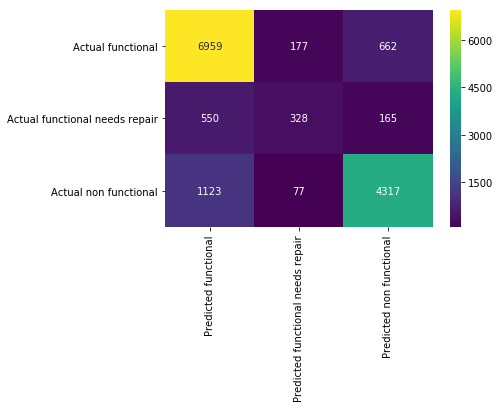

In [ ]:
# 3. Plot a heatmap
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='.0f', cmap='viridis')

plot_confusion_matrix(y_val, y_pred);

#### How many correct predictions were made?

In [ ]:
6959 + 328 + 4317

11604

In [ ]:
sum(y_pred == y_val)

11604

#### How many total predictions were made?

In [ ]:
6959 + 177 + 662 + 550 + 328 + 165 + 1123 + 77 + 4317

14358

In [ ]:
len(y_pred)

14358

#### What was the classification accuracy?

In [ ]:
correct_predictions = 11604
total_predictions = 14358
print('Accuracy', correct_predictions / total_predictions)

Accuracy 0.8081905557877141


In [ ]:
sum(y_pred == y_val) / len(y_pred)

0.8081905557877141

In [ ]:
np.mean(y_pred == y_val)

0.8081905557877141

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred)

0.8081905557877141

## Use classification metrics: precision, recall
[Scikit-Learn User Guide — Classification Report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.89      0.85      7798
functional needs repair       0.56      0.31      0.40      1043
         non functional       0.84      0.78      0.81      5517

               accuracy                           0.81     14358
              macro avg       0.74      0.66      0.69     14358
           weighted avg       0.80      0.81      0.80     14358



#### Wikipedia, [Precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall)

> Both precision and recall are based on an understanding and measure of relevance.

> Suppose a computer program for recognizing dogs in photographs identifies 8 dogs in a picture containing 12 dogs and some cats. Of the 8 identified as dogs, 5 actually are dogs (true positives), while the rest are cats (false positives). The program's precision is 5/8 while its recall is 5/12.

> High precision means that an algorithm returned substantially more relevant results than irrelevant ones, while high recall means that an algorithm returned most of the relevant results.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="400">

#### [We can get precision & recall from the confusion matrix](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context))

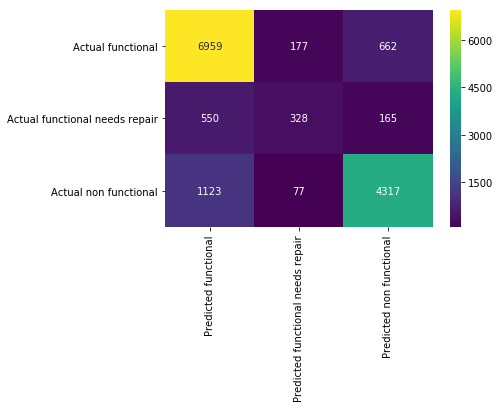

In [ ]:
plot_confusion_matrix(y_val, y_pred);

#### How many correct predictions of "non functional"?

In [ ]:
correct_predictions_nonfunctional = 4317

#### How many total predictions of "non functional"?

In [ ]:
total_predictions_nonfunctional = 4351 + 156 + 622

#### What's the precision for "non functional"?

In [ ]:
print('Precision', correct_predictions_nonfunctional / total_predictions_nonfunctional)

Precision 0.8416845388964711


#### How many actual "non functional" waterpumps?

In [ ]:
actual_nonfunctional = 1123 + 77 + 4317

#### What's the recall for "non functional"?

In [ ]:
print('Recall', correct_predictions_nonfunctional / actual_nonfunctional)

Recall 0.7824904839586732


## Understand the relationships between precision, recall, thresholds, and predicted probabilities. Understand how Precision@K can help make decisions and allocate budgets

### Imagine this scenario...

Suppose there are over 14,000 waterpumps that you _do_ have some information about, but you _don't_ know whether they are currently functional, or functional but need repair, or non-functional.

In [ ]:
len(test)

14358

**You have the time and resources to go to just 2,000 waterpumps for proactive maintenance.** You want to predict, which 2,000 are most likely non-functional or in need of repair, to help you triage and prioritize your waterpump inspections.

You have historical inspection data for over 59,000 other waterpumps, which you'll use to fit your predictive model.

In [ ]:
len(train) + len(val)

59400

You have historical inspection data for over 59,000 other waterpumps, which you'll use to fit your predictive model.

Based on this historical data, if you randomly chose waterpumps to inspect, then about 46% of the waterpumps would need repairs, and 54% would not need repairs.

In [ ]:
y_train.value_counts(normalize=True)

functional                 0.543071
non functional             0.384241
functional needs repair    0.072688
Name: status_group, dtype: float64

**Can you do better than random at prioritizing inspections?**

In this scenario, we should define our target differently. We want to identify which waterpumps are non-functional _or_ are functional but needs repair:

In [ ]:
y_train = y_train != 'functional'
y_val = y_val != 'functional'
y_train.value_counts(normalize=True)

False    0.543071
True     0.456929
Name: status_group, dtype: float64

We already made our validation set the same size as our test set.

In [ ]:
len(val) == len(test)

True

We can refit our model, using the redefined target.

Then make predictions for the validation set.

In [ ]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

And look at the confusion matrix:

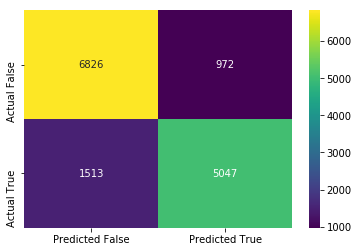

In [ ]:
plot_confusion_matrix(y_val, y_pred);

#### How many total predictions of "True" ("non functional" or "functional needs repair") ?

In [ ]:
5047 + 972

6019

#### We don't have "budget" to take action on all these predictions

- But we can get predicted probabilities, to rank the predictions. 
- Then change the threshold, to change the number of positive predictions, based on our budget.

### Get predicted probabilities and plot the distribution

In [ ]:
# Instead of discrete predictions ...
pipeline.predict(X_val)

array([ True,  True, False, ..., False,  True, False])

In [ ]:
# ... get probabilities:
pipeline.predict_proba(X_val)

array([[0.  , 1.  ],
       [0.22, 0.78],
       [0.86, 0.14],
       ...,
       [0.85, 0.15],
       [0.49, 0.51],
       [0.98, 0.02]])

In [ ]:
# Just get column with index 1
y_pred_proba = pipeline.predict_proba(X_val)[:,1]
y_pred_proba

array([1.  , 0.78, 0.14, ..., 0.15, 0.51, 0.02])

### Change the threshold

False    12247
True      2111
dtype: int64

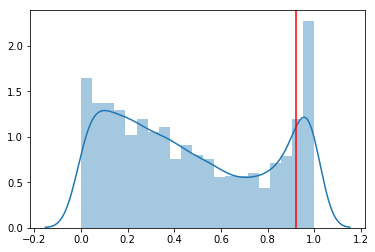

In [ ]:
threshold = 0.92
ax = sns.distplot(y_pred_proba)
ax.axvline(threshold, color='red')

y_pred = y_pred_proba > threshold
pd.Series(y_pred).value_counts()

In [ ]:
from ipywidgets import interact, fixed
import matplotlib.pyplot as plt

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba > threshold
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.show()
    plot_confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))
    
interact(set_threshold, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_proba), 
         threshold=(0,1,0.05));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

### In this scenario ... 

Accuracy _isn't_ the best metric!

Instead, change the threshold, to change the number of positive predictions, based on the budget. (You have the time and resources to go to just 2,000 waterpumps for proactive maintenance.)

Then, evaluate with the precision for "non functional"/"functional needs repair".

This is conceptually like **Precision@K**, where k=2,000.

Read more here: [Recall and Precision at k for Recommender Systems: Detailed Explanation with examples](https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54)

> Precision at k is the proportion of recommended items in the top-k set that are relevant

> Mathematically precision@k is defined as: `Precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)`

> In the context of recommendation systems we are most likely interested in recommending top-N items to the user. So it makes more sense to compute precision and recall metrics in the first N items instead of all the items. Thus the notion of precision and recall at k where k is a user definable integer that is set by the user to match the top-N recommendations objective.

We asked, can you do better than random at prioritizing inspections?

If we had randomly chosen waterpumps to inspect, we estimate that only 920 waterpumps would be repaired after 2,000 maintenance visits. (46%)

But using our predictive model, in the validation set, we succesfully identified over 1,600 waterpumps in need of repair!

So we will use this predictive model with the dataset of over 14,000 waterpumps that we _do_ have some information about, but we _don't_ know whether they are currently functional, or functional but need repair, or non-functional.

We will predict which 2,000 are most likely non-functional or in need of repair.

We estimate that approximately 1,600 waterpumps will be repaired after these 2,000 maintenance visits.

So we're confident that our predictive model will help triage and prioritize waterpump inspections.